# 4. Correcciones de Flat 
El propósito de las correcciones flat es compensar cualquier falta de uniformidad en la respuesta del CCD a la luz. Puede haber varias razones por las que la respuesta no es uniforme en todo el detector:

Variaciones en la sensibilidad de los píxeles en el detector, aunque esta fuente suele ser pequeña.

    Polvo en el filtro o en la ventana de vidrio que cubre el detector.

    Viñeteado, un oscurecimiento en las esquinas de la imagen.

    Cualquier otra cosa en el camino óptico que afecte la cantidad de luz que llega al sensor.

La solución para la falta de uniformidad es la misma en todos los casos: tome una imagen en la que la iluminación sea uniforme y utilícela para medir la respuesta del CCD.

Desafortunadamente, lograr una iluminación uniforme es difícil y es imposible una iluminación uniforme con el mismo espectro que los objetos astronómicos de interés.

# 4.1.1. Descripción general de la toma de imágenes para correcciones Flat 
Hay algunas formas de tomar imágenes "flat":

Las llanuras crepusculares son imágenes del cielo cerca del cenit tomadas alrededor del amanecer o el atardecer.

Los planos de cúpula son imágenes del interior de la cúpula (normalmente de una superficie lisa, no de la cúpula en sí), iluminada por alguna fuente de luz en la cúpula. Para telescopios más pequeños, se puede usar un panel electroluminiscente o iluminado por LED como fuente de luz.

Sky flats se componen de varias imágenes científicas.

Idealmente, las imágenes flat tienen cuentas bastante altas (aproximadamente la mitad de las cuentas máximas del detector) para que la única fuente importante de error sea el error de Poisson debido a la luz en las imágenes flat, y para que la relación señal-ruido en esas imágenes es esencialmente cero.

# 4.1.2. Calibración y combinación de imágenes flat 
El proceso de calibración y combinación de marcos planos es básicamente el mismo independientemente de la fuente de luz que se utilice.

Es útil pensar en marcos planos como imágenes científicas de estrellas o galaxias. El telescopio está tomando una imagen de una fuente de luz, por lo que es necesario eliminar el sesgo y la oscuridad de las imágenes individuales.

Al combinar las imágenes, hay un nuevo paso que aún no hemos discutido: normalizar (también llamado cambiar la escala) los marcos planos calibrados a una media o mediana común antes de combinarlos. Tanto en el cielo como en el crepúsculo, la iluminación varía naturalmente de un cuadro a otro. Si las imágenes no se escalan a un valor común antes de combinarlas, las que se tomen mientras el cielo está más brillante dominarán inapropiadamente el resultado. Las cúpulas deben ser, en principio, perfectamente estables sin variación temporal en su iluminación. En la práctica, cada fuente de luz varía en algún nivel; si está tratando de corregir diferencias del 1% en la iluminación, entonces las fluctuaciones del 1% en la fuente de luz importan.

Por lo general, la media o la mediana se escalan a 1,0 antes de combinarse, de modo que cuando las imágenes científicas se dividen por los planos combinados calibrados, los valores de las imágenes científicas no cambian demasiado.

# 4.2. Calibrando los pisos 
Recuerde que los conteos en una imagen astronómica incluyen corriente oscura, ruido y un desplazamiento casi constante, el sesgo. Los marcos planos individuales deben tener el sesgo y la oscuridad eliminados de ellos. Dependiendo de los tiempos de exposición de las imágenes que tenga, es posible que necesite o no restar la oscuridad y el sesgo por separado.

Si es necesario escalar el cuadro oscuro combinado a un tiempo de exposición diferente, entonces el sesgo y la oscuridad deben manejarse por separado; de lo contrario, la oscuridad y el sesgo se pueden eliminar en un solo paso porque los marcos oscuros también incluyen sesgo.

Los posibles pasos de reducción para marcos planos son los siguientes:

Restar overscan y recorte, si es necesario.

Reste el sesgo, si es necesario.

Reste la corriente oscura, escalando si es necesario (reduzca la escala cuando sea posible).

Como en los capítulos sobre sesgo y oscuridad, trabajaremos con dos ejemplos. En el Ejemplo 1, los oscuros no están escalados y la región de sobreexploración se usa como parte de la calibración. En el Ejemplo 2, los oscuros se escalan y la región de sobreexploración se recorta sin utilizar.

# 4.2.1. Definición de función 
La siguiente función encuentra el tiempo de exposición oscuro más cercano al tiempo de exposición de una imagen determinada. Se genera una excepción si la diferencia en el tiempo de exposición es mayor que tolerance, a menos que tolerancese establezca en None. Una pequeña tolerancia numérica es más útil si prevé no escalar los cuadros oscuros y encontrar un tiempo de exposición oscuro cercano al tiempo de la imagen. Ignorar la tolerancia es útil si la intención es escalar los marcos oscuros de todos modos.

In [2]:
def find_nearest_dark_exposure(image, dark_exposure_times, tolerance=0.5):
    """
    Find the nearest exposure time of a dark frame to the exposure time of the image,
    raising an error if the difference in exposure time is more than tolerance.
    
    Parameters
    ----------
    
    image : astropy.nddata.CCDData
        Image for which a matching dark is needed.
    
    dark_exposure_times : list
        Exposure times for which there are darks.
    
    tolerance : float or ``None``, optional
        Maximum difference, in seconds, between the image and the closest dark. Set
        to ``None`` to skip the tolerance test.
    
    Returns
    -------
    
    float
        Closest dark exposure time to the image.
    """

    dark_exposures = np.array(list(dark_exposure_times))
    idx = np.argmin(np.abs(dark_exposures - image.header['exptime']))
    closest_dark_exposure = dark_exposures[idx]

    if (tolerance is not None and 
        np.abs(image.header['exptime'] - closest_dark_exposure) > tolerance):
        
        raise RuntimeError('Closest dark exposure time is {} for flat of exposure '
                           'time {}.'.format(closest_dark_exposure, image.header['exptime']))
        
    
    return closest_dark_exposure

In [3]:
from pathlib import Path

from astropy import units as u
from astropy.nddata import CCDData
import ccdproc as ccdp
from matplotlib import pyplot as plt
import numpy as np

from convenience_functions import show_image

In [4]:
# Use custom style for larger fonts and figures
plt.style.use('guide.mplstyle')

# 4.2.2. Ejemplo 1: Sin escalado de marcos oscuros 
Las imágenes de este ejemplo son del chip 0 de la Cámara de Gran Formato en el Observatorio Palomar. Las imágenes sin procesar están en Zenodo , y este cuaderno asume que ha trabajado en los cuadernos en sesgo y oscuridad, por lo que hay una carpeta llamada example1-reduceden la misma carpeta que este cuaderno.

Veremos este ejemplo dos veces: una vez con una sola imagen para explicar cada paso y luego nuevamente para procesar todos los marcos planos en el directorio de datos sin procesar.

A continuación se define una colección de imágenes, junto con un par de configuraciones útiles para este ejemplo.

In [5]:
reduced_path = Path('example1-reduced')

ifc_reduced = ccdp.ImageFileCollection(reduced_path)

combined_dark_files = ifc_reduced.files_filtered(imagetyp='dark', combined=True)

flat_image_type = 'FLATFIELD'

In [6]:
raw_data = Path('example-cryo-LFC')

ifc_raw = ccdp.ImageFileCollection(raw_data)

In [7]:
n_combined_dark = len(combined_dark_files)
expected_exposure_times = set([7, 70, 300])

if n_combined_dark < 3:
    raise RuntimeError('One or more combined dark is missing. Please re-run the dark notebook.')
elif n_combined_dark > 3:
    raise RuntimeError('There are more combined dark frames than expected.')
    
actual_exposure_times = set(h['exptime'] for h in ifc_reduced.headers(imagetyp='dark', combined=True))

if (expected_exposure_times - actual_exposure_times):
    raise RuntimeError('Encountered unexpected exposure time in combined darks. '
                       'The unexpected times are {}'.format(actual_exposure_times - expected_exposure_times))

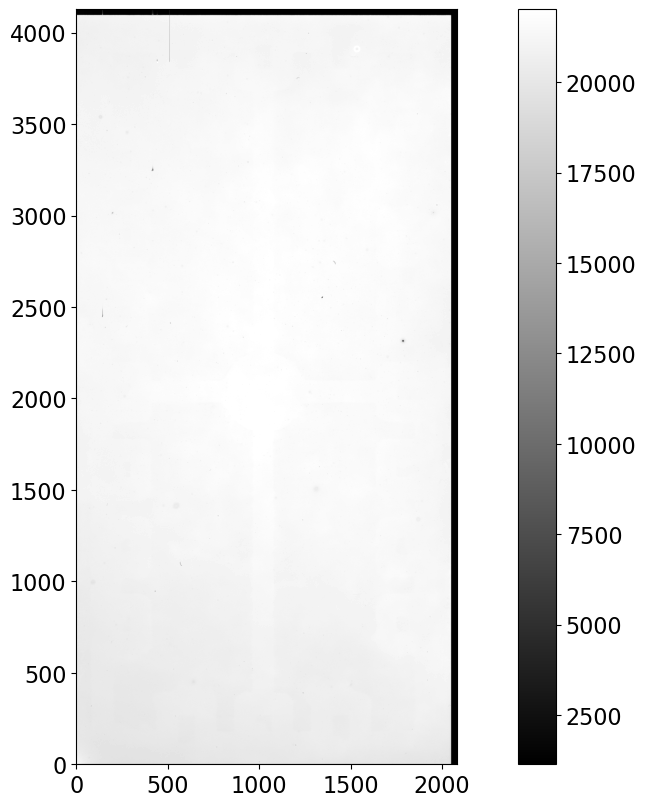

In [8]:
a_flat = CCDData.read(ifc_raw.files_filtered(imagetyp='flatfield', include_path=True)[0], unit='adu')

show_image(a_flat, cmap='gray')

No hay mucha variación en esto. Tenga en cuenta que la región de sobreexploración de la derecha se destaca como una barra negra, y aparentemente también hay una región de sobreexploración en la parte superior del chip. Parece haber una ligera variación en los valores de píxeles desde la parte inferior hasta la parte superior de la imagen.

# 4.2.2.1. Restar overscan y recortar, si es necesario 
El overscan es útil para el LFC y debe restarse y recortarse. Vea este ejemplo en el cuaderno de reducción oscura para una revisión de los parámetros de sobreexploración. La región de sobreexploración es el segmento de Python , mientras que la región que se conservará después del recorte es el segmento de Python .[:, 2055:][:, :2048]

Text(0.5, 1.0, 'Single flat frame, overscan subtracted and trimmed')

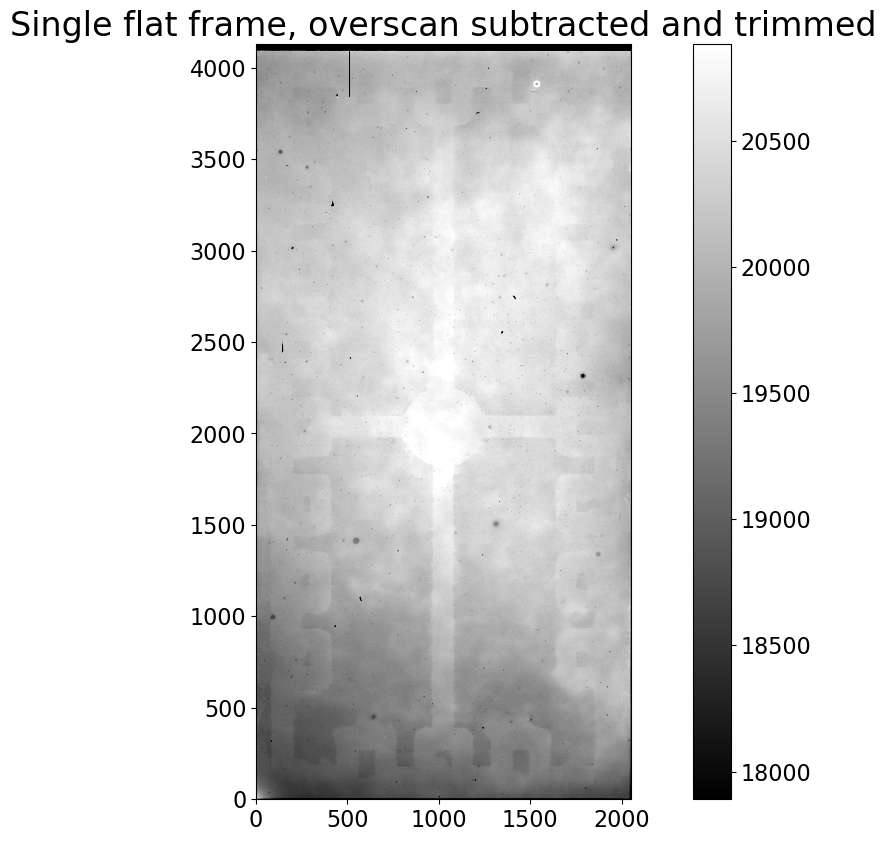

In [9]:
# Subtract the overscan
a_flat_reduced = ccdp.subtract_overscan(a_flat, overscan=a_flat[:, 2055:], median=True)

# Trim the overscan
a_flat_reduced = ccdp.trim_image(a_flat_reduced[:, :2048])

# Display the result so far
show_image(a_flat_reduced, cmap='gray')
plt.title('Single flat frame, overscan subtracted and trimmed')

Recortar el overscan hace una gran diferencia principalmente porque el estiramiento de la imagen cambió; los valores de píxeles más bajos ahora están alrededor de 18000 en lugar de 2000. Con ese cambio, la falta de uniformidad en el detector es mucho más clara.

# 4.2.2.2. No es necesario restar el sesgo en este ejemplo 
Para este conjunto particular de imágenes, hay oscuros con tiempo de exposición de 7, 70 y 300 segundos. Las imágenes planas tienen los tiempos de exposición que se indican a continuación:

In [10]:
set(ifc_raw.summary['exptime'][ifc_raw.summary['imagetyp'] == 'FLATFIELD'])

{7.0, 70.001, 70.011}

# 4.2.2.3. Reste la corriente oscura, no es necesario escalar en este ejemplo 
Necesitamos restar la oscuridad sin escalarla. En lugar de averiguar manualmente qué oscuro restar, usamos el cuadro oscuro más cercano en tiempo de exposición al piso, dentro de una tolerancia de 1 segundo para asegurarnos de no terminar usando un oscuro demasiado lejos en el tiempo de exposición del piso.

Primero, encuentre el tiempo de exposición oscuro más cercano al plano. Tendremos que hacer esto nuevamente más adelante en el cuaderno, por lo que definimos una función para hacerlo.

In [11]:
closest_dark = find_nearest_dark_exposure(a_flat_reduced, actual_exposure_times)

In [12]:
combined_darks = {ccd.header['exptime']: ccd for ccd in ifc_reduced.ccds(imagetyp='dark', combined=True)}

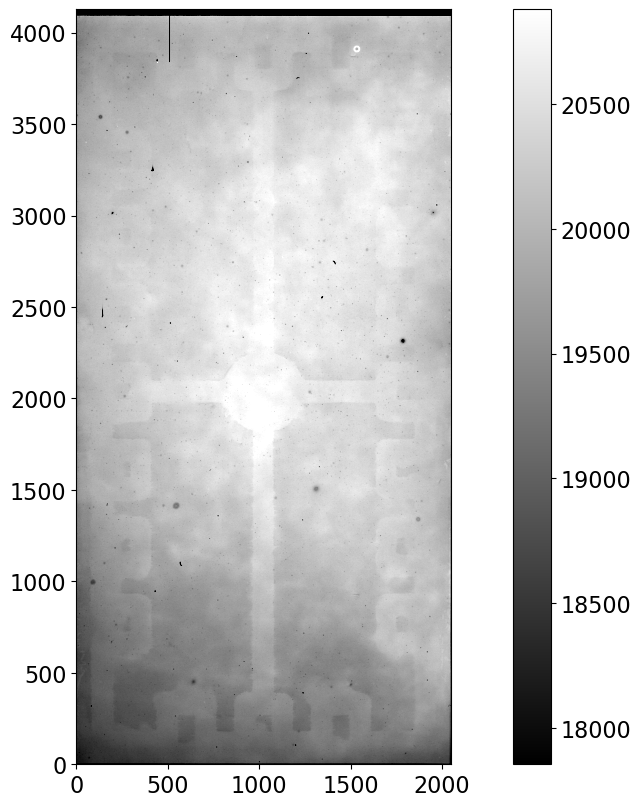

In [13]:
a_flat_reduced = ccdp.subtract_dark(a_flat_reduced, combined_darks[closest_dark], 
                                    exposure_time='exptime', exposure_unit=u.second, scale=False)
show_image(a_flat_reduced, cmap='gray')

No hay mucho cambio aquí; eso no es sorprendente ya que la corriente oscura en esta cámara es baja.

# 4.2.2.4. Calibrar todos los pisos en la carpeta 
La celda a continuación calibra cada uno de los pisos en la carpeta, seleccionando automáticamente la oscuridad combinada correcta para cada piso.

In [14]:
for ccd, file_name in ifc_raw.ccds(imagetyp='FLATFIELD',            # Just get the bias frames
                                         ccd_kwargs={'unit': 'adu'}, # CCDData requires a unit for the image if 
                                                                     # it is not in the header
                                         return_fname=True           # Provide the file name too.
                                        ):    
    # Subtract the overscan
    ccd = ccdp.subtract_overscan(ccd, overscan=ccd[:, 2055:], median=True)
    
    # Trim the overscan
    ccd = ccdp.trim_image(ccd[:, :2048])
    
    # Find the correct dark exposure
    closest_dark = find_nearest_dark_exposure(ccd, actual_exposure_times)
    
    # Subtract the dark current 
    ccd = ccdp.subtract_dark(ccd, combined_darks[closest_dark],
                             exposure_time='exptime', exposure_unit=u.second)

    # Save the result; there are some duplicate file names so pre-pend "flat"
    ccd.write(reduced_path / ('flat-' + file_name))

# 4.2.3. Ejemplo 2: Se escalan los marcos oscuros 
Las imágenes de este ejemplo, como en los cuadernos anteriores, es un CCD enfriado termoeléctricamente descrito con más detalle en el cuaderno de overscan .

Veremos este ejemplo dos veces: una vez con una sola imagen para explicar cada paso y luego nuevamente para procesar todos los marcos planos en el directorio de datos sin procesar.

A continuación se define una colección de imágenes, junto con un par de configuraciones útiles para este ejemplo.

In [15]:
reduced_path = Path('example2-reduced')

ifc_reduced = ccdp.ImageFileCollection(reduced_path)

combined_dark_files = ifc_reduced.files_filtered(imagetyp='dark', combined=True)

flat_image_type = 'FLAT'

In [16]:
raw_data = Path('example-thermo-electric')

ifc_raw = ccdp.ImageFileCollection(raw_data)

In [17]:
n_combined_dark = len(combined_dark_files)

n_dark_expected = 1
expected_exposure_times = set([90])

if n_combined_dark < n_dark_expected:
    raise RuntimeError('One or more combined dark is missing. Please re-run the dark notebook.')
elif n_combined_dark > n_dark_expected:
    raise RuntimeError('There are more combined dark frames than expected.')
    
actual_exposure_times = set(h['exptime'] for h in ifc_reduced.headers(imagetyp='dark', combined=True))

if (expected_exposure_times - actual_exposure_times):
    raise RuntimeError('Encountered unexpected exposure time in combined darks. '
                       'The unexpected times are {}'.format(actual_exposure_times - expected_exposure_times))

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


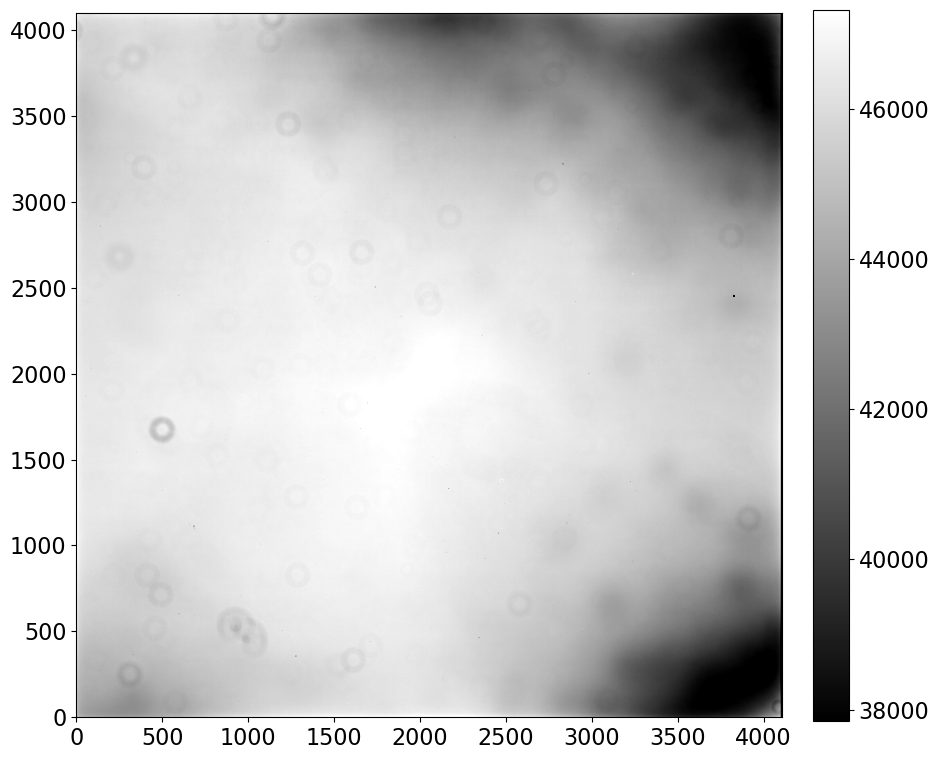

In [18]:
a_flat = CCDData.read(ifc_raw.files_filtered(imagetyp='flat', include_path=True)[0], unit='adu')

show_image(a_flat, cmap='gray')

Hay un patrón de variación muy diferente a través del sensor en este caso que en el Ejemplo 1. Las múltiples "donas" en la imagen son pedazos de polvo y hay un viñeteado (oscurecimiento) significativo en las esquinas superior e inferior de la imagen en la parte superior. lado derecho.

# 4.2.3.1. Resta overscan y recorte: solo recorte para esta cámara 
El overscan no es útil para esta cámara. La región que se conservará después del recorte es el segmento de Python .[:, :4096]

Text(0.5, 1.0, 'Single flat frame, overscan trimmed')

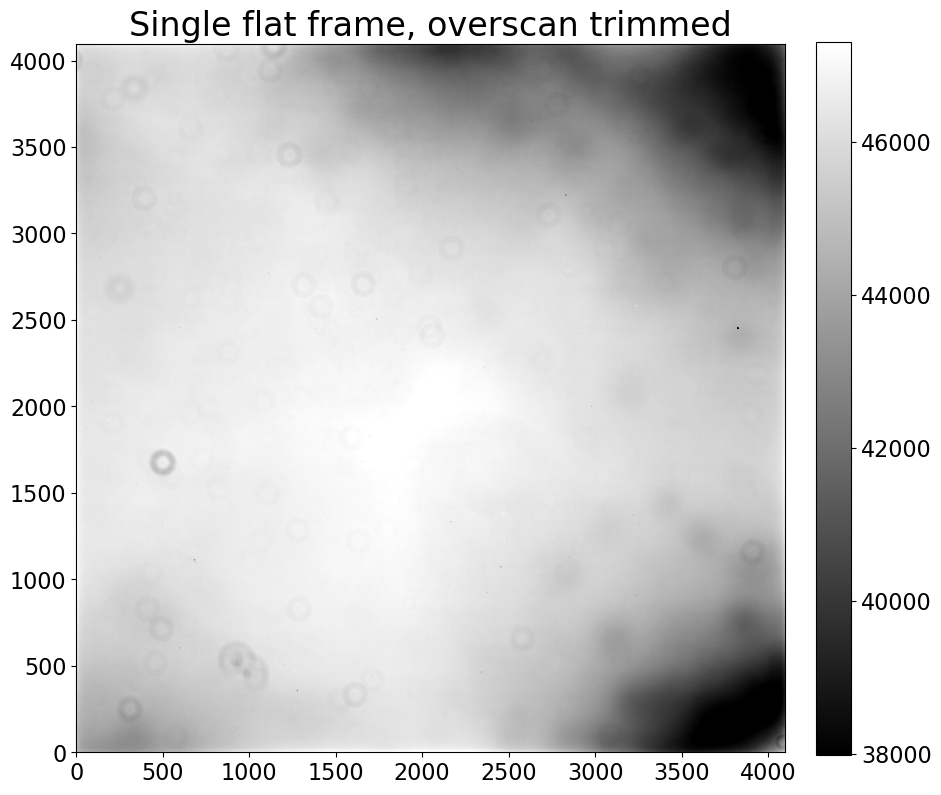

In [19]:
# Trim the overscan
a_flat_reduced = ccdp.trim_image(a_flat[:, :4096])

# Display the result so far
show_image(a_flat_reduced, cmap='gray')
plt.title('Single flat frame, overscan trimmed')

Recortar el overscan no marcó una gran diferencia principalmente porque la región de overscan de esta cámara no es útil. Un overscan útil habría tenido valores alrededor del nivel de polarización de esta cámara, alrededor de 1200 conteos. El estiramiento de la imagen cambió un poco; antes de recortar, el extremo inferior de la escala de colores era 38000 y ahora es 40000.

# 4.2.3.2. Restar sesgo es necesario 
Para este conjunto particular de imágenes, hay una oscuridad combinada con un tiempo de exposición de 90 segundos. Las imágenes planas tienen los tiempos de exposición que se indican a continuación:

In [20]:
set(ifc_raw.summary['exptime'][ifc_raw.summary['imagetyp'] == 'FLAT'])

{1.0, 1.02, 1.06, 1.11, 1.16, 1.21}

In [21]:
combined_bias = list(ifc_reduced.ccds(combined=True, imagetyp='bias'))[0]
a_flat_reduced = ccdp.subtract_bias(a_flat_reduced, combined_bias)

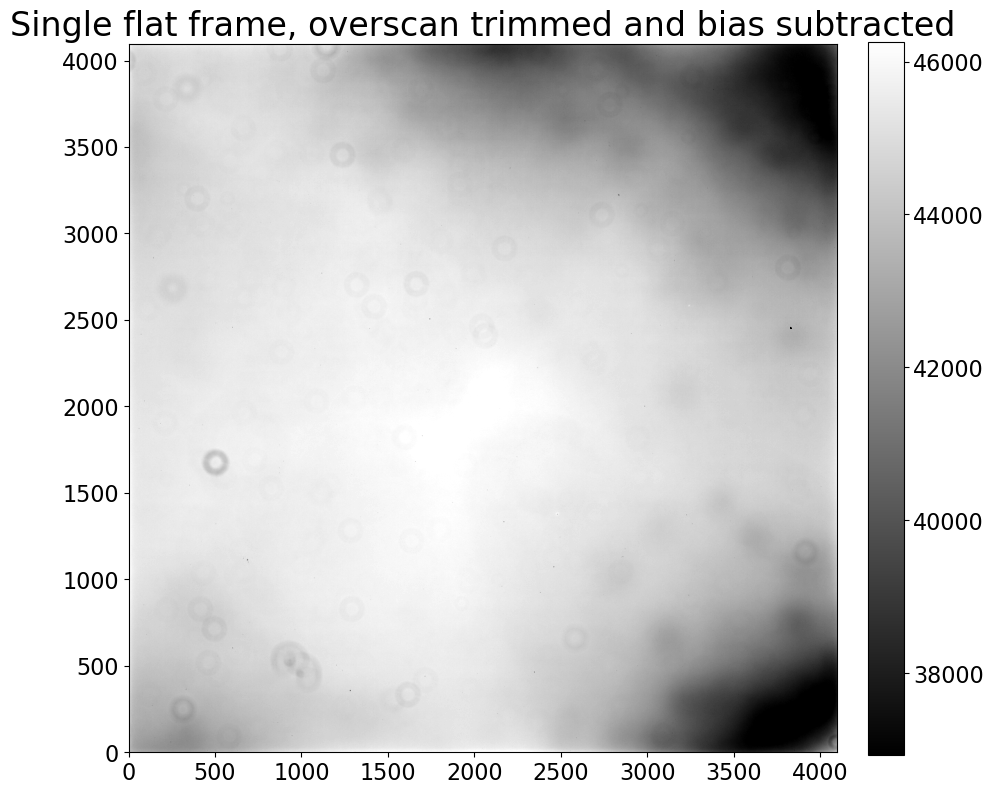

In [22]:
# Display the result so far
show_image(a_flat_reduced, cmap='gray')
plt.title('Single flat frame, overscan trimmed and bias subtracted');

Excepto por un cambio en la escala de la imagen que se muestra en la barra de colores, no hay mucha diferencia visual después de restar el sesgo.

# 4.2.3.3. Reste la corriente oscura, escalando según sea necesario 
Aquí necesitaremos escalar la oscuridad desde el tiempo de exposición de 90 segundos del cuadro oscuro hasta el tiempo de exposición de cada imagen plana. La función ccdproc subtract_dark proporciona palabras clave para realizar este escalado automáticamente.

In [23]:
closest_dark = find_nearest_dark_exposure(a_flat_reduced, actual_exposure_times, tolerance=100)

In [24]:
combined_darks = {ccd.header['exptime']: ccd for ccd in ifc_reduced.ccds(imagetyp='dark', combined=True)}
combined_darks

{90.0: CCDData([[  6.8,  49.7,  39.4, ...,   5.6,   6. ,   1.9],
          [  3. ,  55.3,  33.3, ...,   7.9,  -3.3,   4.6],
          [ -2.4,  49.5,  36.5, ...,   8.4,   4.5,   8.7],
          ...,
          [  2.7,   5.9,   9.4, ...,  -1.8,   7.5,   2.7],
          [  0.4,  13.4,   7.4, ...,  -0.7,  12. ,  -3.3],
          [  0.1, -11.7,   3.1, ...,  -0.9,   2.6,   4.5]], unit='adu')}

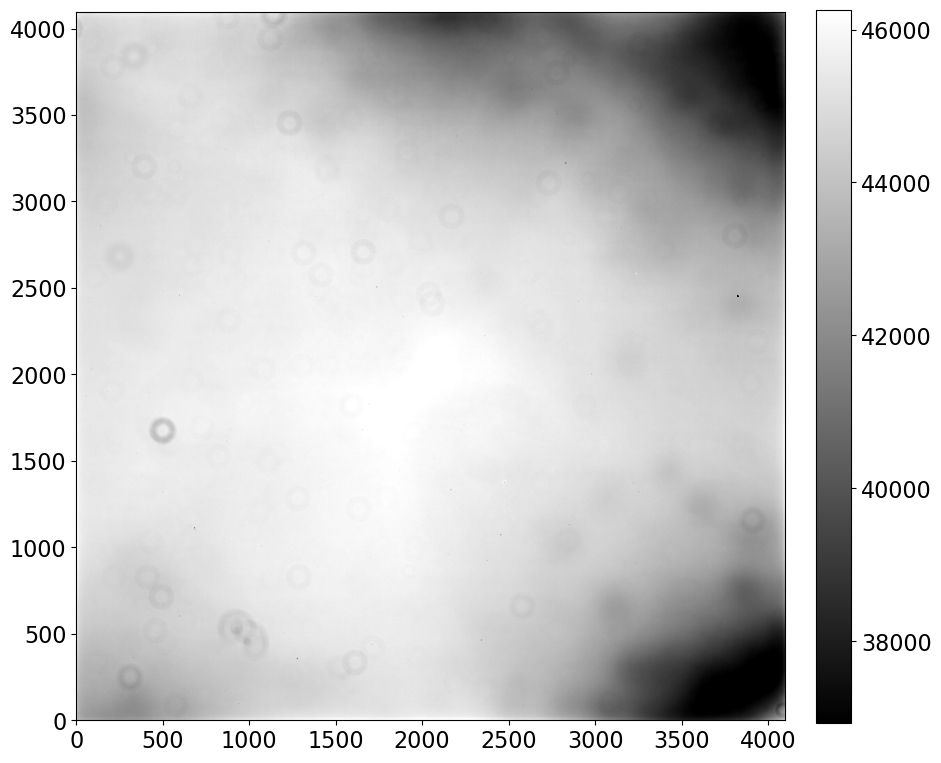

In [25]:
a_flat_reduced = ccdp.subtract_dark(a_flat_reduced, combined_darks[closest_dark], 
                                    exposure_time='exptime', exposure_unit=u.second, scale=True)
show_image(a_flat_reduced, cmap='gray')

No hay mucho cambio aquí; eso no es sorprendente ya que la corriente oscura en esta cámara es baja.

# 4.2.3.4. Calibrar todos los pisos en la carpeta 
La celda a continuación calibra cada uno de los pisos en la carpeta, seleccionando automáticamente la oscuridad combinada correcta para cada piso.

In [ ]:
for ccd, file_name in ifc_raw.ccds(imagetyp='FLAT',            # Just get the bias frames
                                   return_fname=True           # Provide the file name too.
                                  ):
        
    # Trim the overscan
    ccd = ccdp.trim_image(ccd[:, :4096])
    
    # Find the correct dark exposure
    closest_dark = find_nearest_dark_exposure(ccd, actual_exposure_times, tolerance=100)
    
    # Subtract the dark current 
    ccd = ccdp.subtract_dark(ccd, combined_darks[closest_dark],
                             exposure_time='exptime', exposure_unit=u.second, scale=True)

    # Save the result
    ccd.write(reduced_path / file_name)